In [1]:
from qiskit import *
# Qiskit module
from qiskit import QuantumCircuit
import qiskit.circuit.library as circuit_library
import qiskit.quantum_info as qi
import qiskit.ignis.mitigation as mit

# Qiskit tools for running and monitoring jobs
from qiskit import execute
from qiskit.tools.monitor import job_monitor

from qiskit.tools.visualization import *
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.special import erf
# Other imports
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)
# Qiskit for pulse 
from qiskit import pulse

from qiskit import *
from qiskit.pulse import Play, Schedule, DriveChannel, ControlChannel, Waveform, ShiftPhase
from qiskit.pulse.library import drag, GaussianSquare, Drag
from qiskit.visualization import SchedStyle
from qiskit.providers.aer import AerSimulator

import qiskit.ignis.mitigation as mit

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

from qiskit.circuit.gate import Gate

# Fake backend
#from qiskit.test.mock import FakeAthens

from scipy import integrate


In [2]:
def h_Z(qc,h,dt,L):
    
    #q0=qubits_list[0]
    
    #q4=qubits_list[4]
    
    for i in range(L):
        if i==0 or i==L-1:
            qc.rz(h*dt,i)
        else:
            qc.rz(2*h*dt,i)
        
def X_Rabi(qc,Omega,dt,L): # Rabi coupling
    
    for i in range(L):
        
        qc.rx(2*Omega*dt,i)
        
def ZZ(qc,V,dt,L): # nearest neighbor coupling
    

    for i in range(1,L-1,2):
        
        qc.rzz(-2*V*dt,i,i+1)
        
    for i in range(0,L-1,2):
        
        qc.rzz(-2*V*dt,i,i+1)

    

In [3]:
def Trotter_circuit_5_site_no_custom(h,Omega,V,T,n,L):
    
    
    Trotter_gates = []
    
    dt=T/n
    
    for i in range(n):
        
        Trotter_circuit = QuantumCircuit(L)#, name=str(i)+'Trots')
        
        ### Initial state setting
        
        #for u in range(1,5,2):
        
        #for u in range(5):
            
            #Trotter_circuit.u1(np.pi,u)
            
        #    Trotter_circuit.x(u)
            
            #Trotter_circuit.h(u)
            
            
        
        #Trotter_circuit.x(1)
        
        #Trotter_circuit.x(3)
        
        ###
        
        Trotter_circuit.barrier()
        
        for k in range(i):
            
            X_Rabi(Trotter_circuit,Omega,dt,L) # Rabi coupling from the second term of Hamiltonian
            
            h_Z(Trotter_circuit,h,dt,L) # Z field 
            
            #Trotter_circuit.barrier()
            
            ZZ(Trotter_circuit,V,dt,L) # Nearest neighbor hopping term
            
            Trotter_circuit.barrier()
        
        #j=0
        
        #for i in range(5):
            
        #    Trotter_circuit.measure(i,j)
            
        #    j+=1
        
        #Trotter_circuit = transpile(Trotter_circuit, backend) # compile into specific backend
        
        Trotter_gates.append(Trotter_circuit.to_instruction())
        
        #Trotter_gates.append(Trotter_circuit.to_gate(label=str(i)+'Trots'))
        
    return Trotter_gates
    

In [6]:
L=12

Omega = 0.24



V = -1

h = 2*V

T = 30  #15 #1.5 # Total time

TT=T

n = 30 #20

NN=n

#qubit_list = [0,1,3,5,4]

#site=2

#Trotter_circuit_no_custom = ZZ_Auto_Correlation_circ(h,Omega,V,T,n,site)

Trotter_gates = Trotter_circuit_5_site_no_custom(h,Omega,V,T,n,L)




In [7]:
def Corr_circuit_YY_site_MG_min(h,Omega,V,T,n,L,si,sj):

    corr_cirs=[]
    
    dt=T/n

    for i in range(n):

        qr = QuantumRegister(L, 'q')

        #anc = QuantumRegister(1, 'ancilla')

        cr = ClassicalRegister(L, 'c')

        qc = QuantumCircuit(qr, cr)
        
        qc.x(qr[1::2])
            
        if si in [j for j in range(1,L,2)]:
            
            pass
        
        else:
            
            qc.x(qr[si])

        qc.h(si)

        qc.s(si)
        
        qc.barrier()
        
        for k in range(i):
            
            X_Rabi(qc,Omega,dt,L) # Rabi coupling from the second term of Hamiltonian
            
            h_Z(qc,h,dt,L) # Z field 
            
            #Trotter_circuit.barrier()
            
            ZZ(qc,V,dt,L) # Nearest neighbor hopping term
            
            qc.barrier()

        #qc.append(Trotter_gates[i], qr[:])

        if sj=='even':

            qc.sdg(qr[0::2])

            qc.h(qr[0::2])
            
        elif sj=='odd':
            
            qc.sdg(qr[1::2])

            qc.h(qr[1::2])

        qc.measure(qr[:],cr[:])

        qc.draw('mpl')

        corr_cirs.append(qc)
        
    return corr_cirs

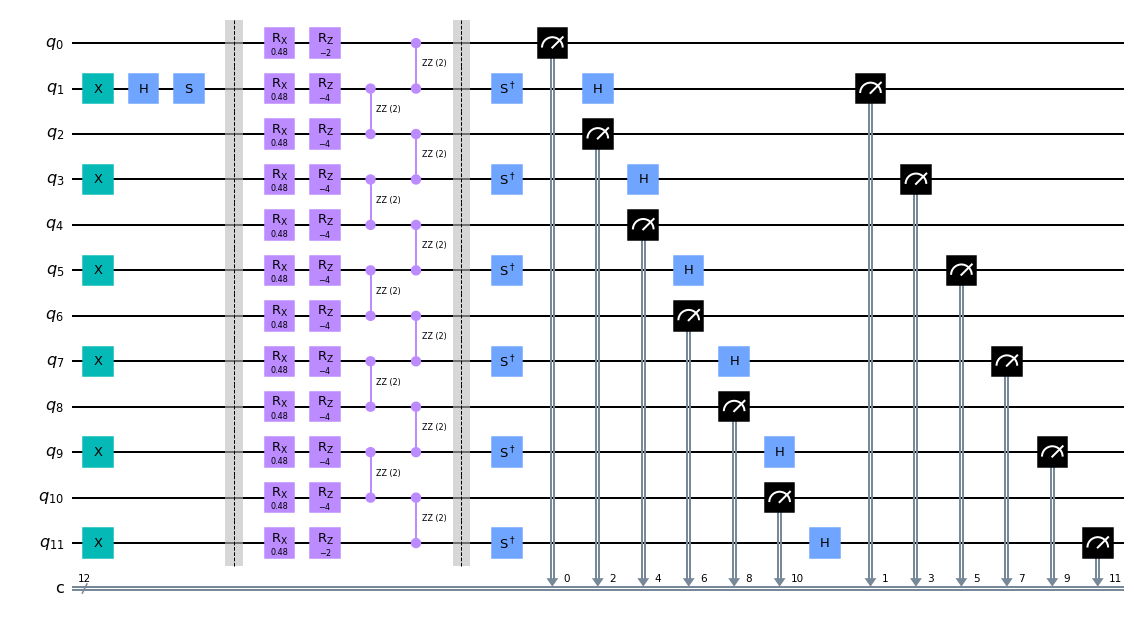

In [9]:
corr_cirs_min=Corr_circuit_YY_site_MG_min(h,Omega,V,T,n,L,1,'odd')

corr_cirs_min[1].draw('mpl')

In [10]:
def Corr_circuit_YY_site_MG_plus(h,Omega,V,T,n,L,si,sj):

    corr_cirs_i=[]
    
    dt=T/n

    for i in range(n):

        qr = QuantumRegister(L, 'q')

        #anc = QuantumRegister(1, 'ancilla')
            
        cr = ClassicalRegister(L, 'c')

        qc = QuantumCircuit(qr, cr)

        qc.x(qr[1::2])

        if si in [j for j in range(1,L,2)]:
            
            qc.x(qr[si])

        qc.h(si)

        qc.s(si)

        qc.barrier()
        
        for k in range(i):
            
            X_Rabi(qc,Omega,dt,L) # Rabi coupling from the second term of Hamiltonian
            
            h_Z(qc,h,dt,L) # Z field 
            
            #Trotter_circuit.barrier()
            
            ZZ(qc,V,dt,L) # Nearest neighbor hopping term
            
            qc.barrier()
            
        if sj=='even':

            qc.sdg(qr[0::2])

            qc.h(qr[0::2])
            
        elif sj=='odd':
            
            qc.sdg(qr[1::2])

            qc.h(qr[1::2])

        qc.measure(qr[:],cr[:])

        corr_cirs_i.append(qc)
        
    return corr_cirs_i

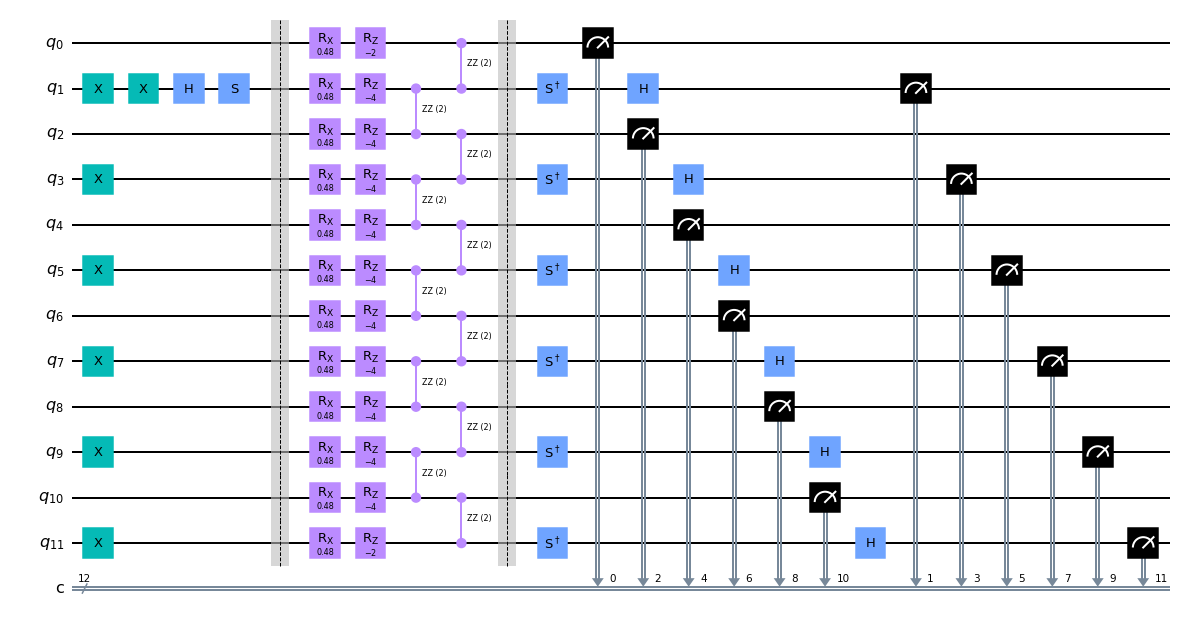

In [11]:
corr_cirs_plus=Corr_circuit_YY_site_MG_plus(h,Omega,V,T,n,L,1,'odd')

corr_cirs_plus[1].draw('mpl')

In [12]:
def Corr_circuit_YY_site_plus(h,Omega,V,T,n,L,si,sj):

    corr_cirs=[]
    
    dt=T/n

    for i in range(n):

        qr = QuantumRegister(L, 'q')

        #anc = QuantumRegister(1, 'ancilla')

        cr = ClassicalRegister(L, 'c')

        qc = QuantumCircuit(qr, cr)

        qc.x(qr[1::2])

        qc.ry(np.pi/2,si)

        qc.barrier()
        
        for k in range(i):
            
            X_Rabi(qc,Omega,dt,L) # Rabi coupling from the second term of Hamiltonian
            
            h_Z(qc,h,dt,L) # Z field 
            
            #Trotter_circuit.barrier()
            
            ZZ(qc,V,dt,L) # Nearest neighbor hopping term
            
            qc.barrier()

        if sj=='even':

            qc.sdg(qr[0::2])

            qc.h(qr[0::2])
            
        elif sj=='odd':
            
            qc.sdg(qr[1::2])

            qc.h(qr[1::2])

        qc.measure(qr[:],cr[:])

        corr_cirs.append(qc)
        
    return corr_cirs

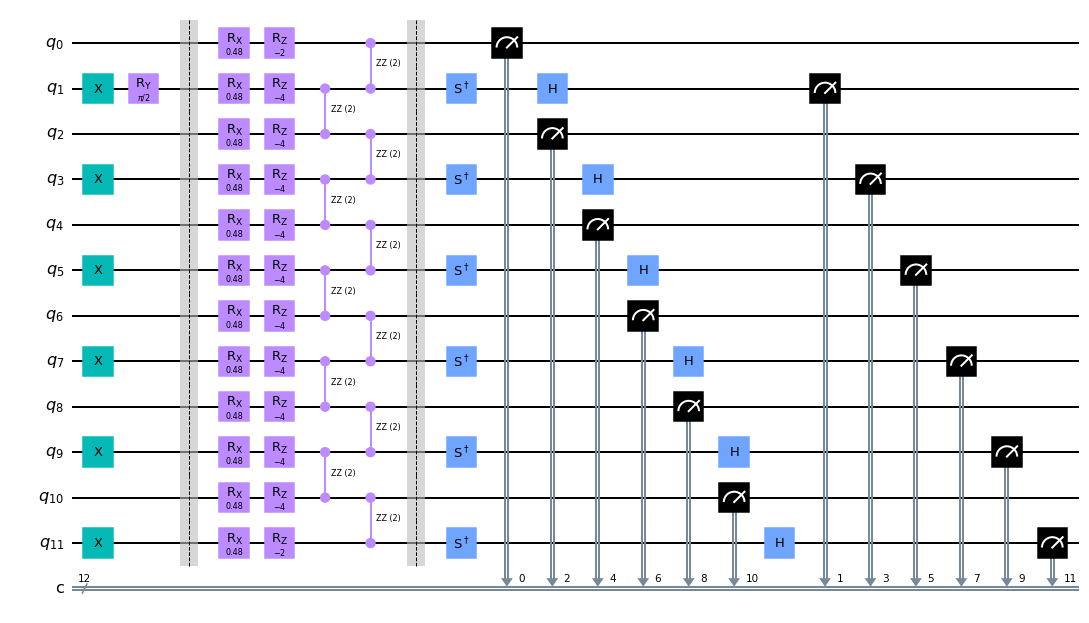

In [13]:
corr_cirs_G_plus=Corr_circuit_YY_site_plus(h,Omega,V,T,n,L,1,'odd')

corr_cirs_G_plus[1].draw('mpl')

In [14]:
def Corr_circuit_YY_site_min(h,Omega,V,T,n,L,si,sj):

    corr_cirs=[]
    
    dt=T/n

    for i in range(len(Trotter_gates)):

        qr = QuantumRegister(L, 'q')

        #anc = QuantumRegister(1, 'ancilla')

        cr = ClassicalRegister(L, 'c')
            
        qc = QuantumCircuit(qr, cr)

        qc.x(qr[1::2])

        qc.ry(-np.pi/2,si)

        qc.barrier()
        
        for k in range(i):
            
            X_Rabi(qc,Omega,dt,L) # Rabi coupling from the second term of Hamiltonian
            
            h_Z(qc,h,dt,L) # Z field 
            
            #Trotter_circuit.barrier()
            
            ZZ(qc,V,dt,L) # Nearest neighbor hopping term
            
            qc.barrier()
            
        if sj=='even':

            qc.sdg(qr[0::2])

            qc.h(qr[0::2])
            
        elif sj=='odd':
            
            qc.sdg(qr[1::2])

            qc.h(qr[1::2])

        qc.measure(qr[:],cr[:])

        corr_cirs.append(qc)
        
    return corr_cirs

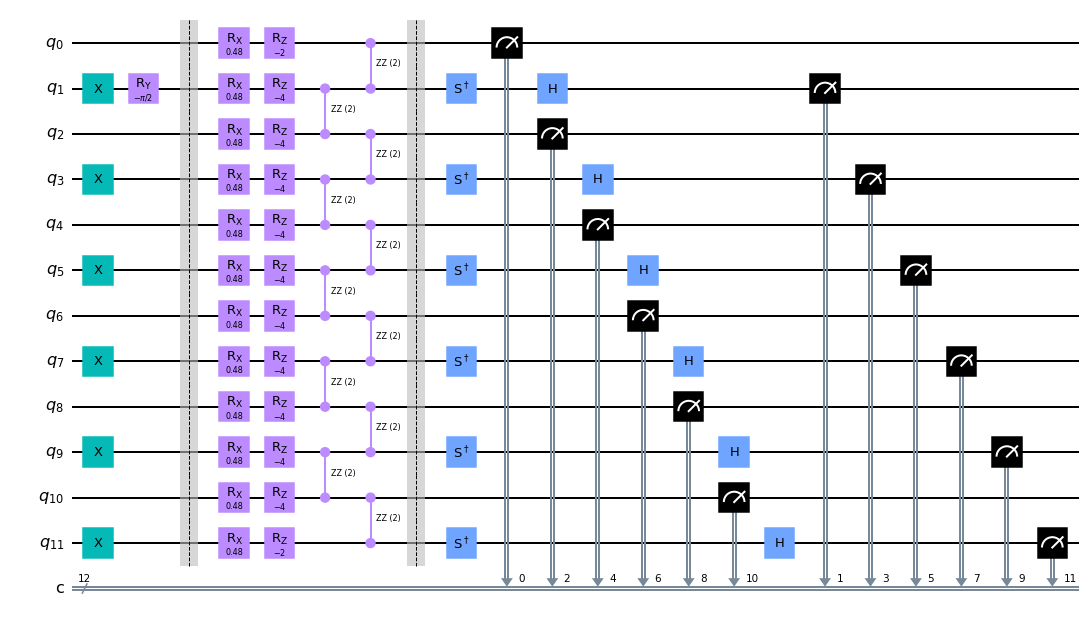

In [15]:
corr_cirs_G_min=Corr_circuit_YY_site_min(h,Omega,V,T,n,L,1,'odd')

corr_cirs_G_min[1].draw('mpl')

# Expectation value

In [16]:
def stabilizer_coeff_pauli(stabilizer):
    """Return the 1 or -1 coeff and Pauli label."""
    coeff = 1
    pauli = coeff
    if stabilizer[0] == '-':
        coeff = -1
    if stabilizer[0] in ['+', '-']:
        pauli = stabilizer[1:]
    else:
        pauli = stabilizer
    return coeff, pauli

def stabilizer_measure_diagonal(stabilizer):
    """Return the diagonal vector for a stabilizer measurement.
    
    Args:
        stabilizer (str): a stabilizer string
    
    Returns:
        np.ndarray: the diagonal for measurement in the stabilizer basis.
    """
    coeff, pauli = stabilizer_coeff_pauli(stabilizer)
    diag = np.array([1])
    for s in reversed(pauli):
        if s == 'I':
            tmp = np.array([1, 1])
        else:
            tmp = np.array([1, -1])
        diag = np.kron(tmp, diag)
    return coeff * diag

def measure_expval(result, stab, meas_mitigator=None):
    
    result_lst = result.get_counts()
    
    result_num = len(result_lst)
    
    #print()
    
    expvals=[]
    
    for i in range(result_num):
    
        expval, stddev = mit.expectation_value(result_lst[i],
                diagonal=stabilizer_measure_diagonal(stab),
                meas_mitigator=meas_mitigator)
        
        expvals.append(expval)
    
    return np.array(expvals)

In [17]:
Tot_r = 0

Tot_i = 0

EvenOdd=['even','odd']

for i in range(1,L,2):
    
    for j in EvenOdd :

        corr_cirs_min=Corr_circuit_YY_site_MG_min(h,Omega,V,T,n,L,i,j)

        corr_cirs_plus=Corr_circuit_YY_site_MG_plus(h,Omega,V,T,n,L,i,j)

        corr_cirs_G_min=Corr_circuit_YY_site_min(h,Omega,V,T,n,L,i,j)

        corr_cirs_G_plus=Corr_circuit_YY_site_plus(h,Omega,V,T,n,L,i,j)
        
        shots = 8192

        corr_cirs_job = execute(corr_cirs_min, Aer.get_backend('qasm_simulator'), shots=shots)

        corr_cirs_i_job = execute(corr_cirs_plus, Aer.get_backend('qasm_simulator'), shots=shots)

        corr_cirs_G_job = execute(corr_cirs_G_plus, Aer.get_backend('qasm_simulator'), shots=shots)

        corr_cirs_G_i_job = execute(corr_cirs_G_min, Aer.get_backend('qasm_simulator'), shots=shots)
        
        results = corr_cirs_job.result()

        results_i = corr_cirs_i_job.result()

        results_G = corr_cirs_G_job.result()

        results_G_i = corr_cirs_G_i_job.result()
        
        if j=='even':
            
            for k in range(0,L,2):
                
                if k < 2:
                    
                    left = 0
                    
                else:
                    
                    left = k-1
                    
                if k > L-3:
                    
                    right = 0
                    
                else:
                    
                    right = L-2-k
                    
                if k == 0:
                    
                    stab = ['YI'+'I'*right,'YZ'+'I'*right]
                    
                elif k==L-1:
                    
                    stab = ['I'*left+'IY','I'*left+'ZY']
                    
                else:
                    
                    stab = ['I'*left+'IYI'+'I'*right,'I'*left+'ZYI'+'I'*right,'I'*left+'IYZ'+'I'*right,'I'*left+'ZYZ'+'I'*right]
        
                expvals=[]

                for stab_str in stab:

                    expval1=measure_expval(results, stab_str[::-1])

                    expval2=measure_expval(results_i, stab_str[::-1])

                    expvals.append((-expval1+expval2)/2)

                Tot_r += ((-1)**(i+k))*np.sum(expvals[q] for q in range(len(expvals)))/len(expvals)

                expvals=[]

                for stab_str in stab:

                    expval1=measure_expval(results_G, stab_str[::-1])

                    expval2=measure_expval(results_G_i, stab_str[::-1])

                    expvals.append((expval1-expval2)/2)

                Tot_i += ((-1)**(i+k))*np.sum(expvals[q] for q in range(len(expvals)))/len(expvals)
                
        if j=='odd':
            
            for k in range(1,L,2):
                
                if k < 2:
                    
                    left = 0
                    
                else:
                    
                    left = k-1
                    
                if k > L-3:
                    
                    right = 0
                    
                else:
                    
                    right = L-2-k
                    
                if k == 0:
                    
                    stab = ['YI'+'I'*right,'YZ'+'I'*right]
                    
                elif k==L-1:
                    
                    stab = ['I'*left+'IY','I'*left+'ZY']
                    
                else:
                    
                    stab = ['I'*left+'IYI'+'I'*right,'I'*left+'ZYI'+'I'*right,'I'*left+'IYZ'+'I'*right,'I'*left+'ZYZ'+'I'*right]
        
                expvals=[]

                for stab_str in stab: #stab[::-1]:

                    expval1=measure_expval(results, stab_str[::-1])

                    expval2=measure_expval(results_i, stab_str[::-1])#

                    expvals.append((-expval1+expval2)/2)

                Tot_r += ((-1)**(i+k))*np.sum(expvals[q] for q in range(len(expvals)))/len(expvals)

                expvals=[]

                for stab_str in stab: #stab[::-1]:

                    expval1=measure_expval(results_G, stab_str[::-1])

                    expval2=measure_expval(results_G_i, stab_str[::-1])

                    expvals.append((expval1-expval2)/2)

                Tot_i += ((-1)**(i+k))*np.sum(expvals[q] for q in range(len(expvals)))/len(expvals)    

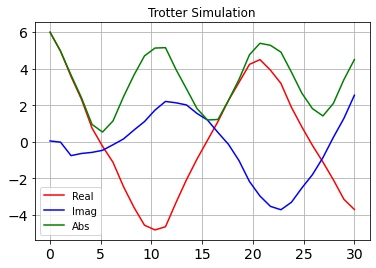

In [18]:
t=np.linspace(0,T,NN)
plt.title("Trotter Simulation")
plt.plot(t,Tot_r,color='r',label='Real')
plt.plot(t,Tot_i,color='b',label='Imag')
plt.plot(t,np.sqrt(Tot_i**2+Tot_r**2),color='g',label='Abs')
#plt.plot(t,(-corr_G+corr_i_G)/2,color='b',label='Trotter simulation')
#plt.plot(t,corr_i,color='b',label='Trotter simulation')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
np.save('YY_corr_real_12site_ch',Tot_r)
np.save('YY_corr_imag_12site_ch',Tot_i)
np.save('YY_corr_abs_12site_ch',np.sqrt(Tot_i**2+Tot_r**2))